# Pseudotime construction
This notebook details the construction and comparison of pseudo time for the epithelial cell development data

## IMporting

In [ ]:
import subprocess

def pip_install(package):
    subprocess.run(["pip", "install", package], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

pip_install("dynamo-release")
pip_install("scanpy")
pip install ("palantir")

restart run time

In [ ]:
from dynamo.preprocessing import Preprocessor
from sklearn.decomposition import PCA
import dynamo as dyn
import numpy as np
import anndata as ad
import scanpy as sc
from pickle import LONG1
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import drive
import palantir

/usr/local/lib/python3.11/dist-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/anndata/utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/anndata/utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/anndata/utils.py:434: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx instead.
  warnings.warn(msg, FutureWarning)
/usr

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Full path to the .h5ad file
file_path = "/content/drive/My Drive/Colab Notebooks/NSC3001/anndata_processed.h5ad"
adata = ad.read_h5ad(file_path)  # Without `backed="r"

In [ ]:
adata

AnnData object with n_obs × n_vars = 3275 × 62710
    obs: 'sample', 'species', 'gene_count', 'tscp_count', 'mread_count', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'Size_Factor', 'initial_cell_size', 'ntr', 'leiden', 'cell_identity', 'cluster_identity'
    var: 'gene_id', 'gene_name', 'genome', 'nCells', 'nCounts', 'pass_basic_filter', 'log_m', 'log_cv', 'score', 'frac', 'use_for_pca', 'ntr'
    uns: 'PCs', 'cell_identity_colors', 'cluster_identity_colors', 'explained_variance_ratio_', 'feature_selection', 'leiden', 'leiden_colors', 'neighbors', 'pca_mean', 'pp', 'umap', 'velocyto_SVR'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

In [ ]:
#sc.pl.umap(adata,color = ['sample','cluster_identity'],legend_loc='on data')

|-----------> plotting with basis key=X_umap
|-----------> skip filtering cluster_identity by stack threshold when stacking color because it is not a numeric type


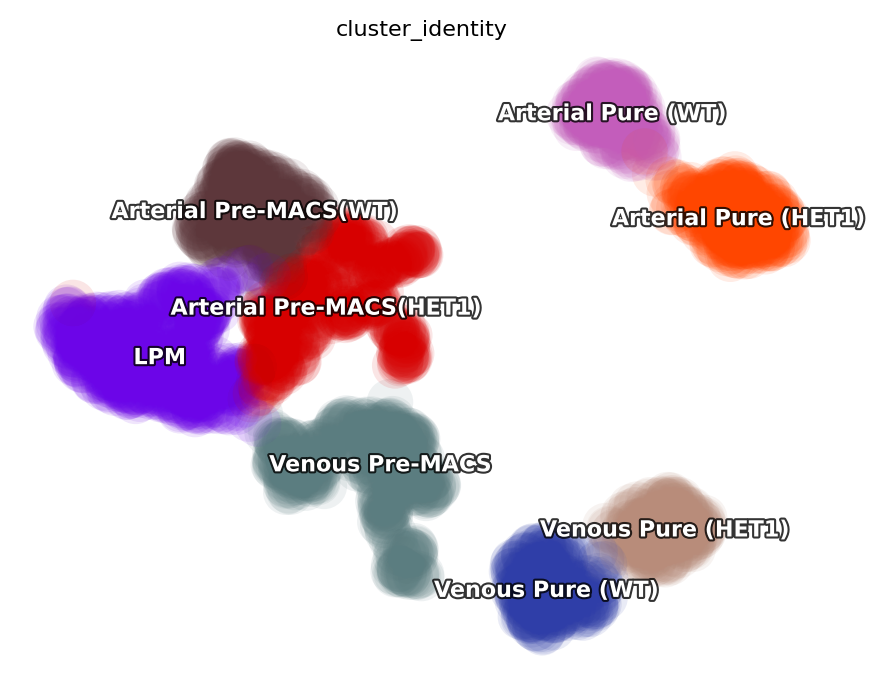

In [ ]:
dyn.pl.umap(adata, color='cluster_identity',
           save_show_or_return='show')

As can be observed here there is significant biological variation between the 2 samples of HET1/WT cells therefore I can have 4 terminal states

# Pseudo temporal ordering
I will use both Palantir and DPT and compare them to detail which is the superior method for this data.

## DPT

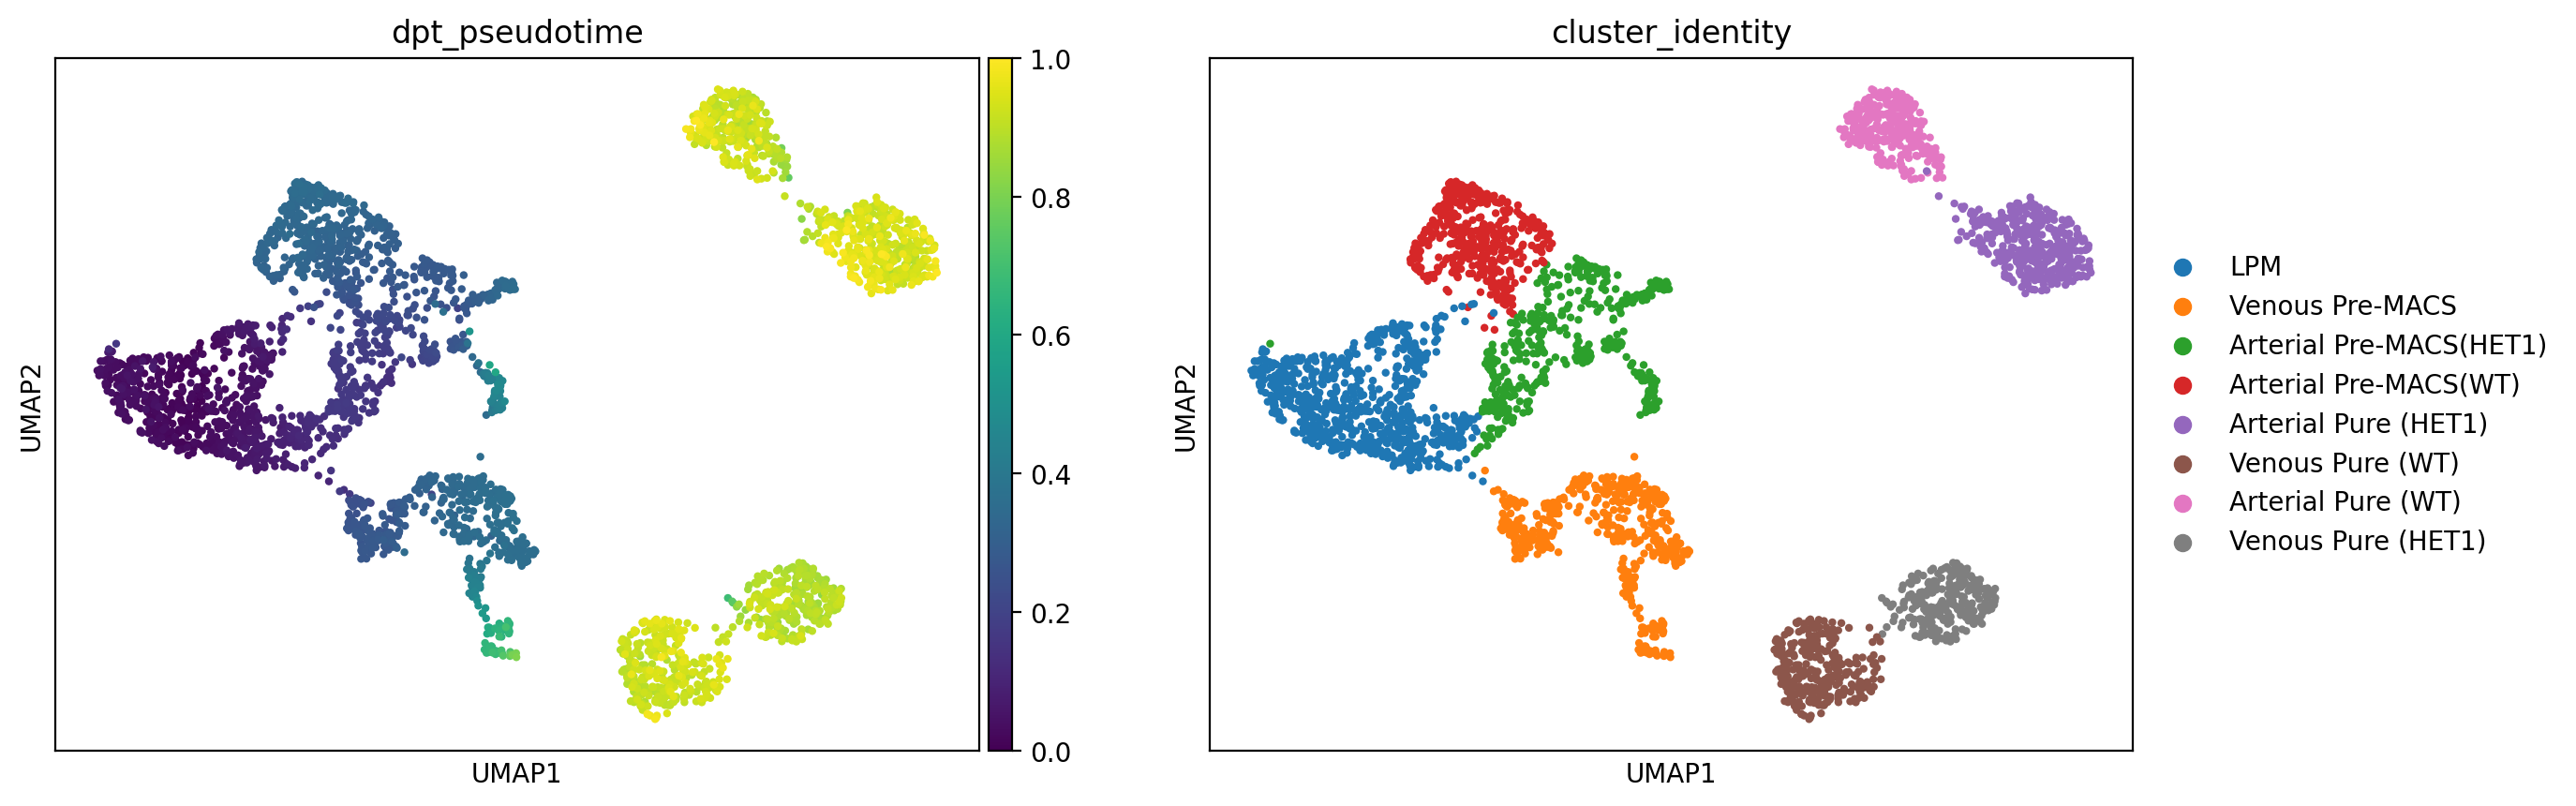

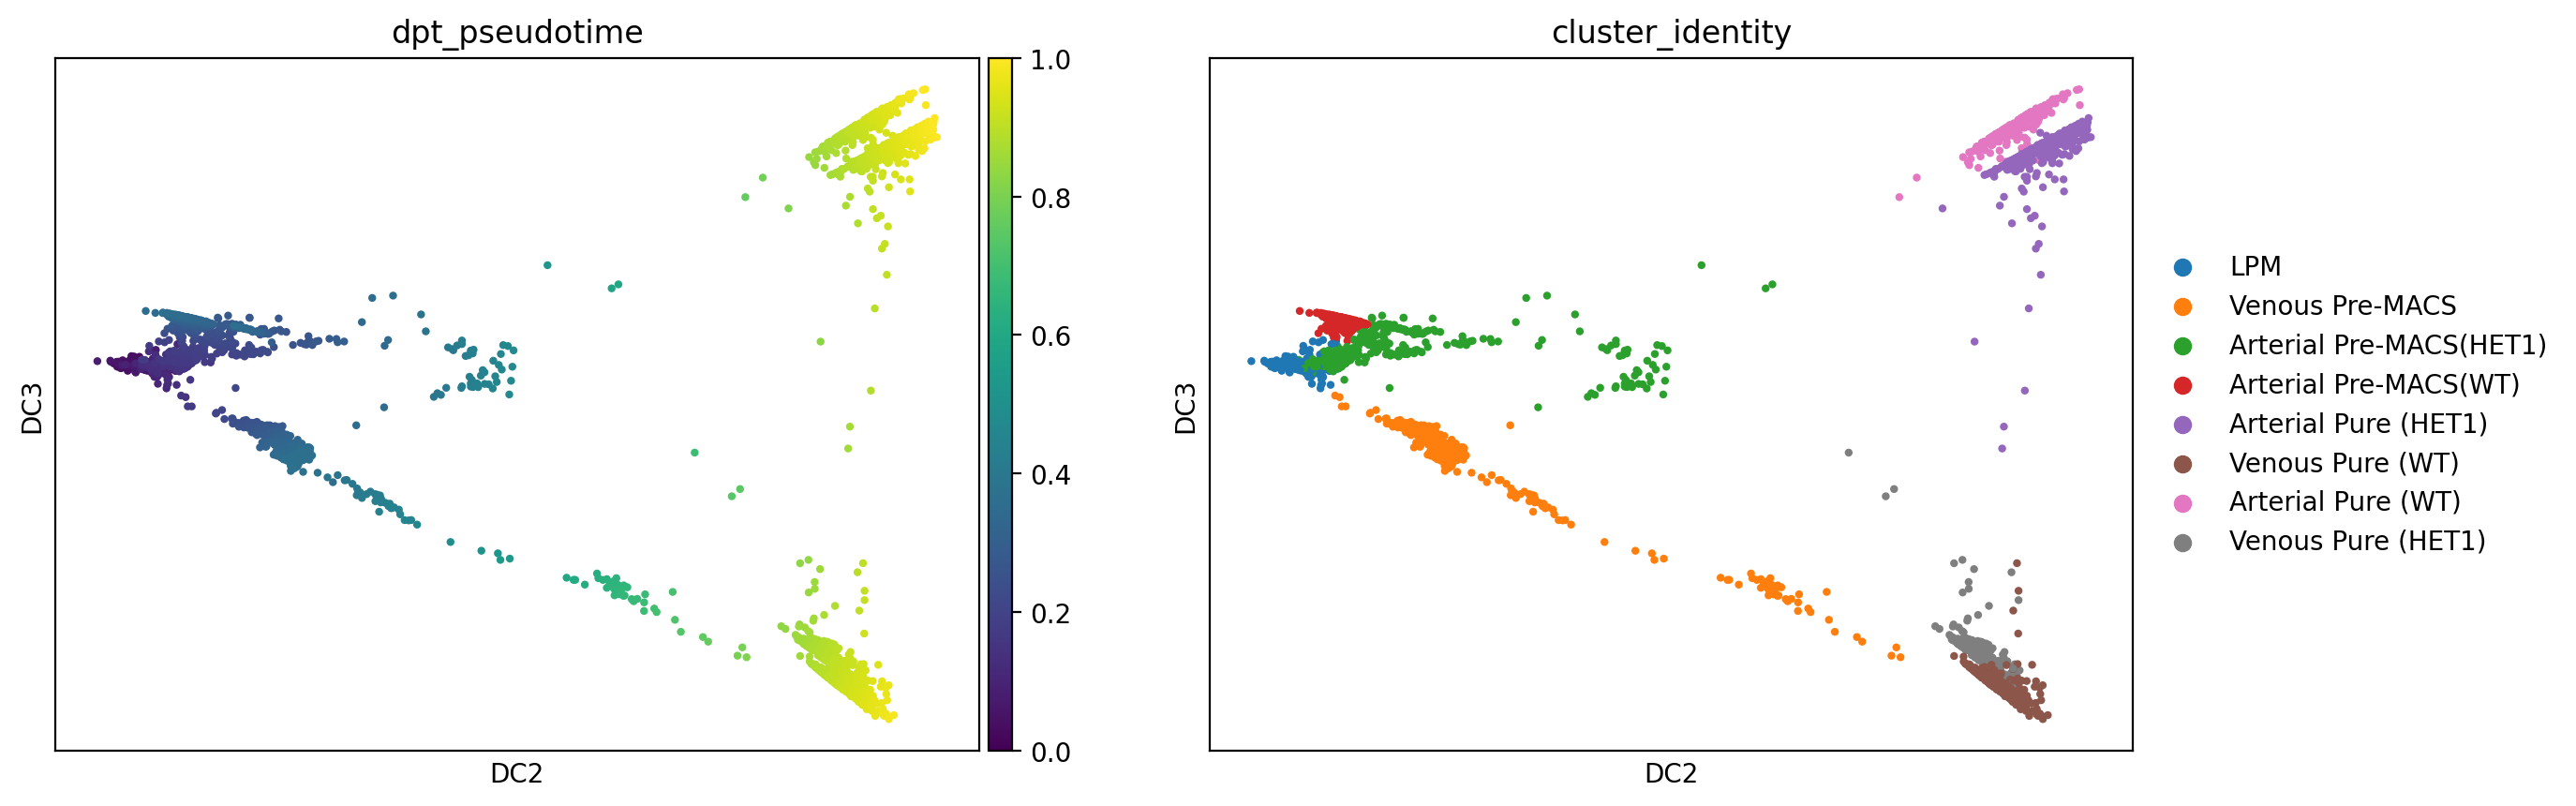

In [ ]:
sc.pp.neighbors(adata, n_neighbors=25)

# Compute diffusion map
sc.tl.diffmap(adata)

# Set root cell as LPM
lpm_mask = adata.obs['cell_identity'].isin(['LPM (WT)', 'LPM (HET1)'])
adata.uns['iroot'] = np.flatnonzero(lpm_mask)[0]

#  Run diffusion pseudotime
sc.tl.dpt(adata)

# Visualise on UMAP
sc.pl.umap(adata, color=['dpt_pseudotime', 'cluster_identity'])

#  visualise on diffmap if needed
sc.pl.diffmap(adata, color=['dpt_pseudotime', 'cluster_identity'], components="2,3")


## Palantir
https://github.com/dpeerlab/Palantir/blob/master/notebooks/Palantir_sample_notebook.ipynb

In [ ]:
dm_res = palantir.utils.run_diffusion_maps(adata, n_components=5)

In [ ]:
ms_data = palantir.utils.determine_multiscale_space(adata)

In [ ]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

In [ ]:
imputed_X = palantir.utils.run_magic_imputation(adata)

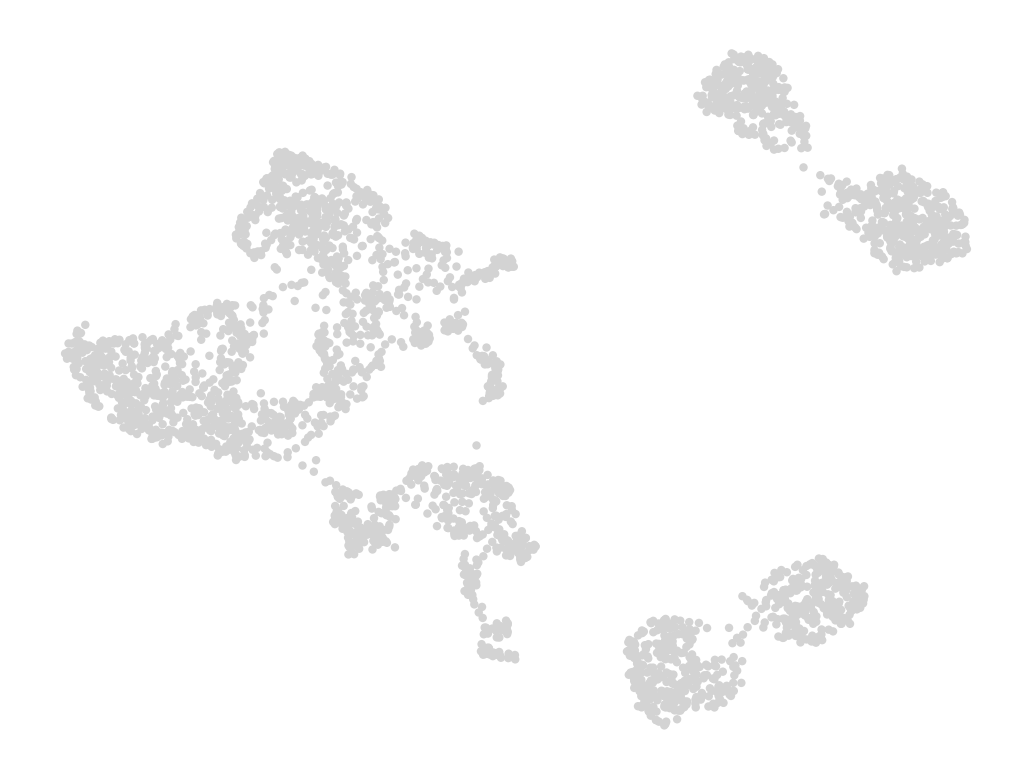

In [ ]:
sc.pl.embedding(
    adata,
    basis="umap",
    layer="MAGIC_imputed_data",
    #color=["CD34", "MPO", "GATA1", "IRF8"],
    frameon=False,
)
plt.show()

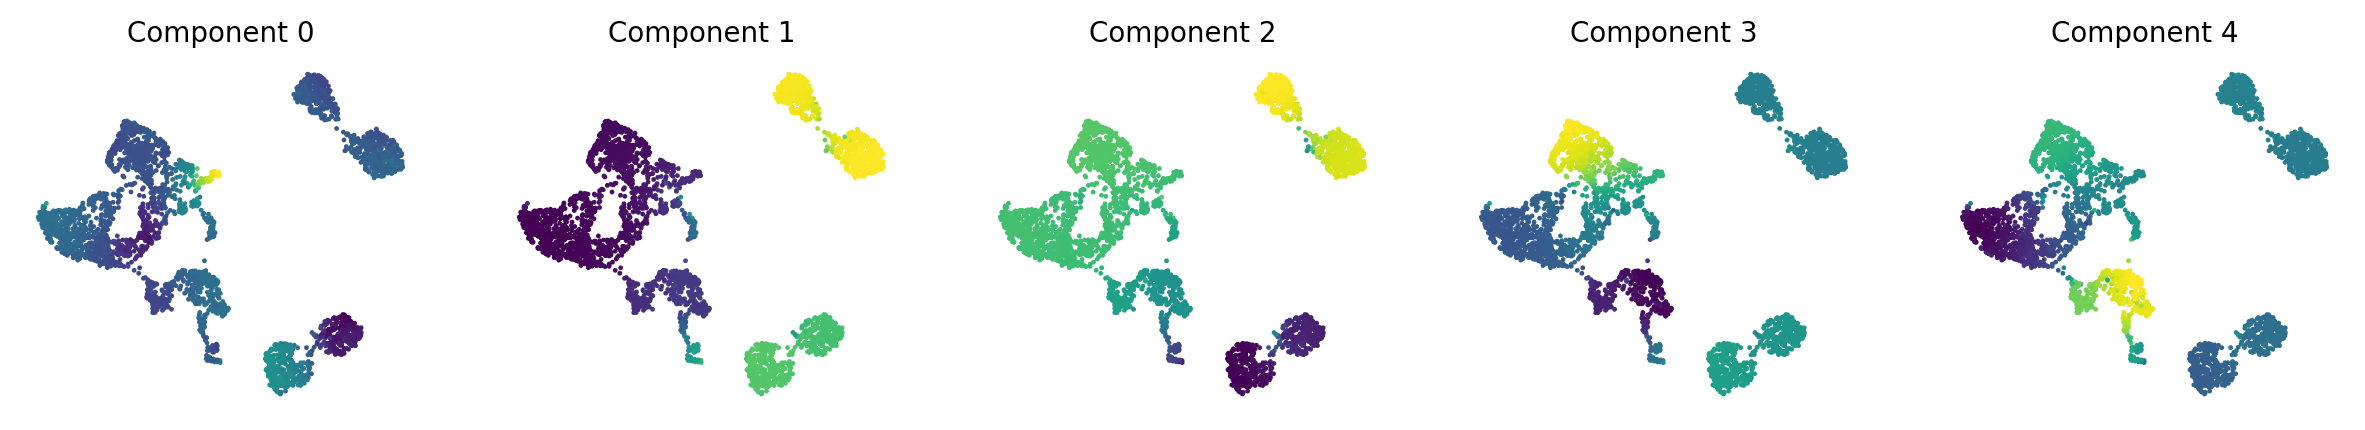

In [ ]:

palantir.plot.plot_diffusion_components(adata)
plt.show()

### Identify key terminal/ root cells


In [ ]:
## Depreciated method
# print(adata.obs['cluster_identity'].unique())

# lpm_cells = adata.obs[adata.obs['cluster_identity'] == 'LPM'].index.tolist()
# print(lpm_cells)

# #determine terminal cell
# candidate_cell_id = "03_48_36"#03_39_35

# # Highlight this cell on the UMAP
# palantir.plot.highlight_cells_on_umap(adata, [candidate_cell_id])
# plt.show()

# #determine terminal cell
# candidate_cell_id = "03_21_42"#03_39_35

# # Highlight this cell on the UMAP
# palantir.plot.highlight_cells_on_umap(adata, [candidate_cell_id])
# import matplotlib.pyplot as plt
# plt.show()

# #manually selected root cell using visualisation
# LPM_cell_id = "03_21_42"
# venous_cell_id = "11_43_55"
# arterial_cell_id = "10_12_31"

# # Get all LPM cells
# lpm_cells = adata.obs[adata.obs['cluster_identity'] == 'LPM'].index

# # Method 1: Manual selection (recommended for clarity)
# root_cell = "YOUR_LPM_CELL_ID"  # Replace with actual ID from lpm_cells

# # Method 2: Automatic selection via pseudotime (requires precomputed)
# root_cell = adata.obs.loc[
#     adata.obs['palantir_pseudotime'].idxmin()
# ].name

# # Method 3: Diffusion component extremum (from ScanPy)
# sc.tl.diffmap(adata)
# root_ix = adata.obsm['X_diffmap'][:, 3].argmin()  # Adjust component as needed
# root_cell = adata.obs_names[root_ix]


In [ ]:
lpm_cells = adata.obs[adata.obs['cluster_identity'] == 'LPM'].index
# venous_cells = adata.obs[adata.obs['cluster_identity'] == 'Venous Pure (WT)' | 'Venous Pure (HET1)'].index
# arterial_cells = adata.obs[adata.obs['cluster_identity'] == 'Arterial Pure (WT)'|'Arterial Pure (HET1)'].index
venous_cells = adata.obs[adata.obs['cluster_identity'] == 'Venous Pure (HET1)'].index
arterial_cells = adata.obs[adata.obs['cluster_identity'] == 'Arterial Pure (HET1)'].index


In [ ]:
# Find extreme cells (leftmost or rightmost)
def bookends(cell_type, direction):
    umap_coords = pd.DataFrame(
        adata.obsm['X_umap'],  # All UMAP coordinates
        index=adata.obs_names   # Cell IDs as index
    )
    cell_umap = umap_coords.loc[cell_type]  # Filter to specified cell type

    # Find extreme cells based on direction
    if direction == 0:
        extreme_cell = cell_umap.iloc[:, 0].idxmin()  # Minimum UMAP1 (leftmost)
        print(f"Progenitor {cell_type.name} cell: {extreme_cell}")
    elif direction == 1:
        extreme_cell = cell_umap.iloc[:, 0].idxmax()  # Maximum UMAP1 (rightmost)
        print(f"Terminal {cell_type.name} cell: {extreme_cell}")

    return extreme_cell


In [ ]:

# Get extreme cells for each type
LPM_cell_id = bookends(lpm_cells, 0)     # Leftmost LPM cell (progenitor)
venous_cell_id = bookends(venous_cells, 1)   # Rightmost venous cell (terminal)
arterial_cell_id = bookends(arterial_cells, 1)  # Rightmost arterial cell (terminal)



Progenitor bc_wells cell: 03_21_42
Terminal bc_wells cell: 12_54_30
Terminal bc_wells cell: 10_06_76


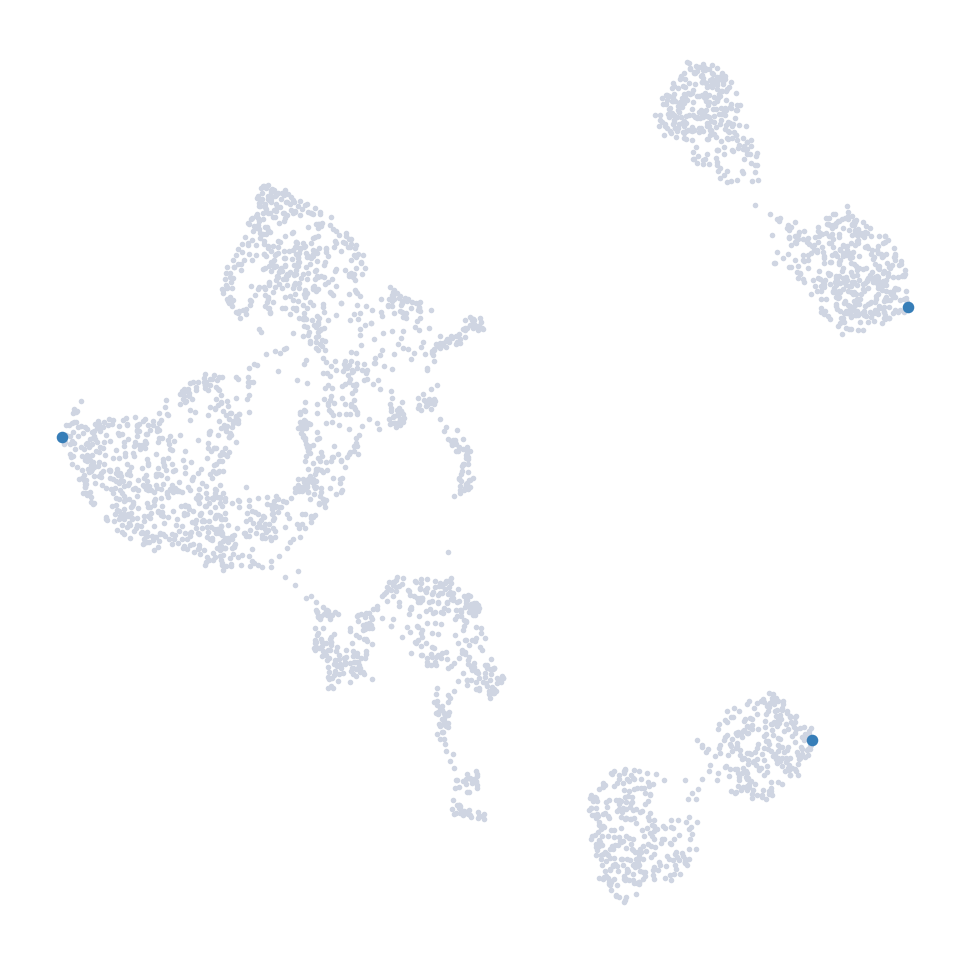

In [ ]:
# Highlight cells on the UMAP
palantir.plot.highlight_cells_on_umap(adata, [LPM_cell_id,venous_cell_id,arterial_cell_id])
plt.show()

# # With Labels
# palantir.plot.highlight_cells_on_umap(adata,terminal_states)
# plt.show()

In [ ]:
# Now you can use these for Palantir
terminal_states = pd.Series(
    ["Venous Pure (HET1)", "Arterial Pure (HET1)"],
    index=[venous_cell_id, arterial_cell_id]
)

What am I doing here? I am attempting to find the ideal terminal cells. As I do not have pre calculated Pseudo time I will be using a mix of visual inspection and filtering of key genes that should be expressed in terminal states

Visualize candidate terminal cells using palantir.plot.highlight_cells_on_umap()

Check that selected cells are not outliers or technically problematic

Verify they represent biologically meaningful end states using known markers

### Palantir Calculation

In [ ]:
start_cell = LPM_cell_id
pr_res = palantir.core.run_palantir(
    adata, start_cell, num_waypoints=500, terminal_states=terminal_states
)

Sampling and flocking waypoints...
Time for determining waypoints: 0.03710700273513794 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.7877500335375468 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


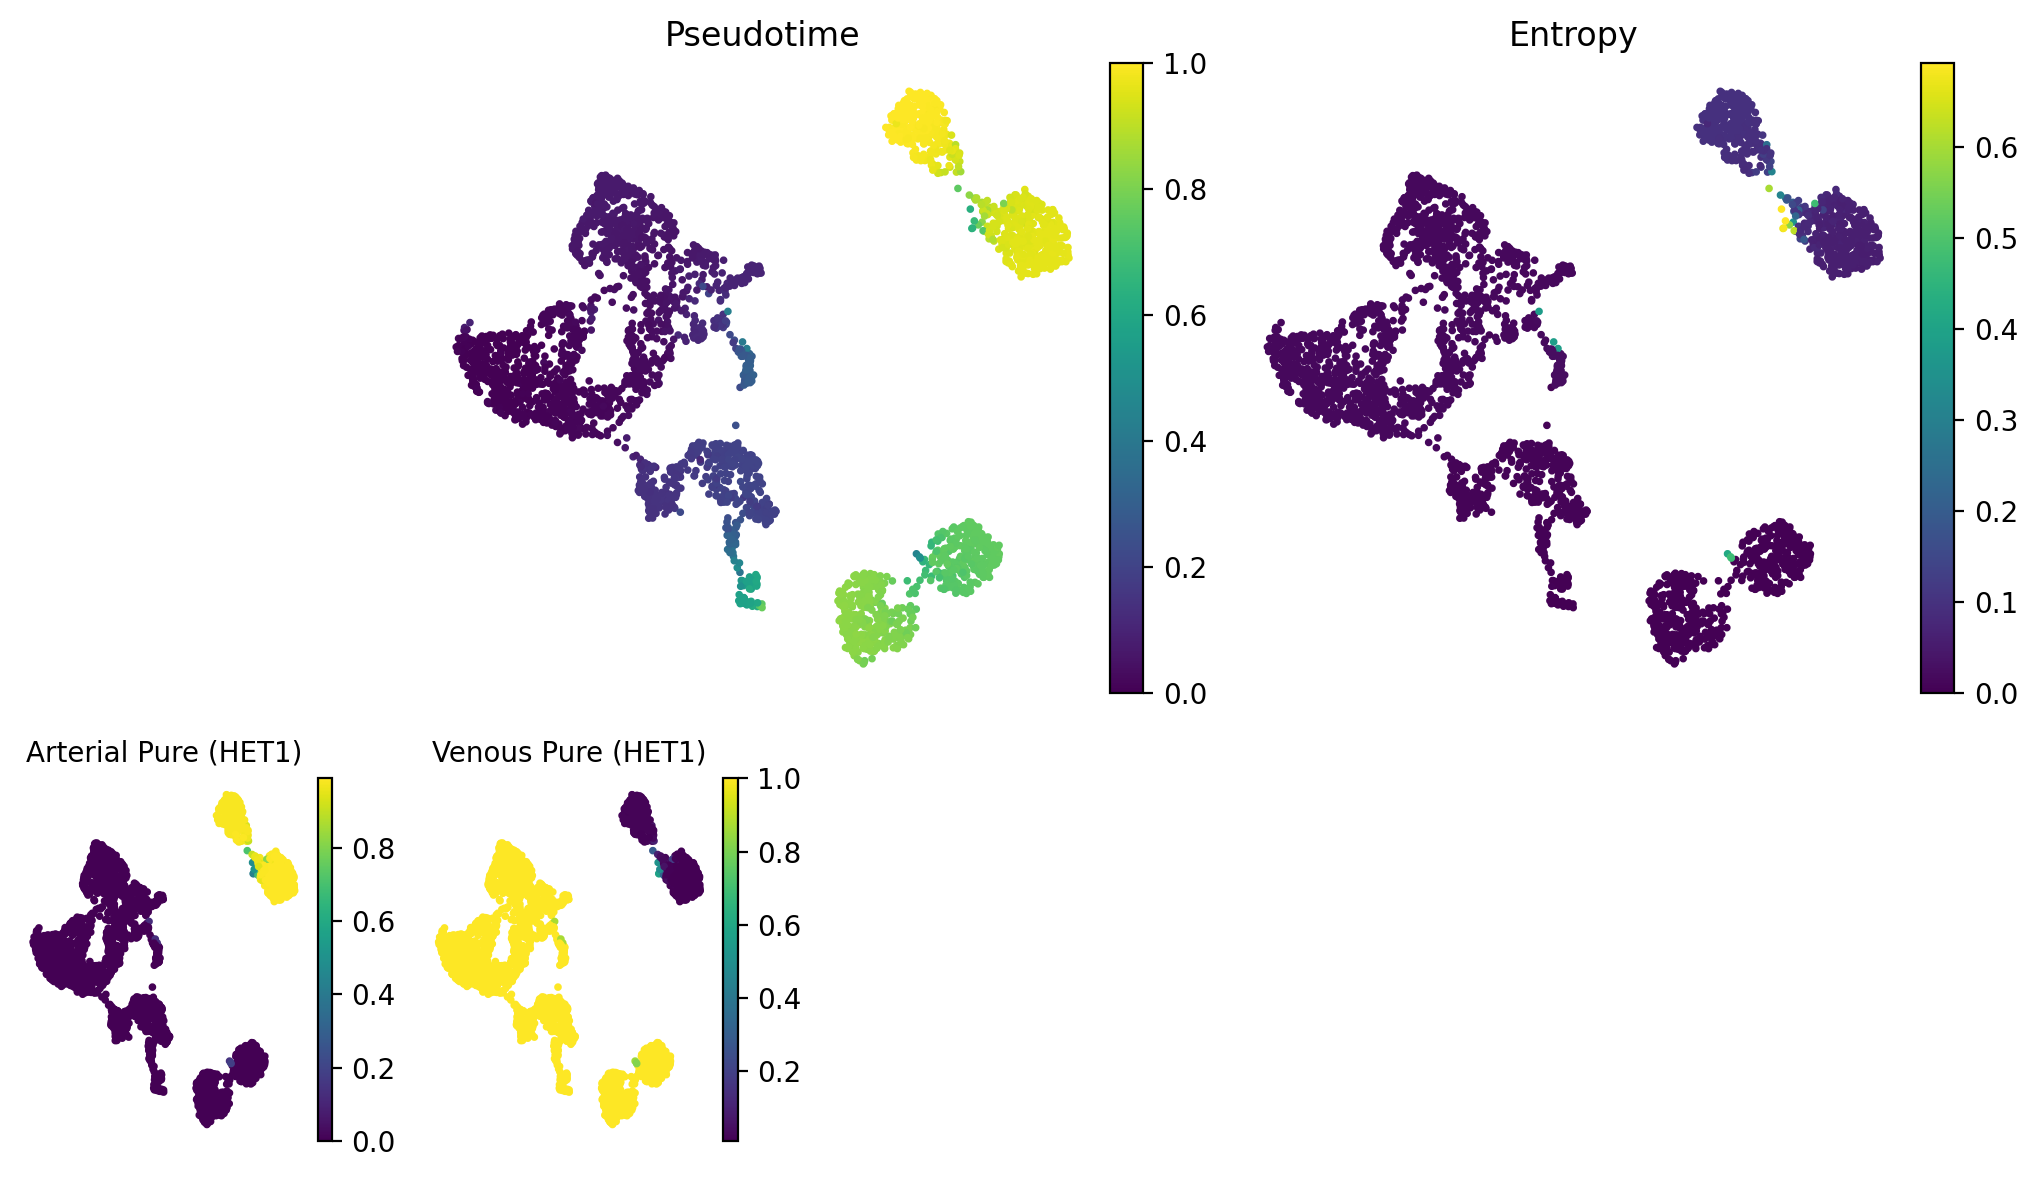

In [ ]:
palantir.plot.plot_palantir_results(adata, s=3)
plt.show()

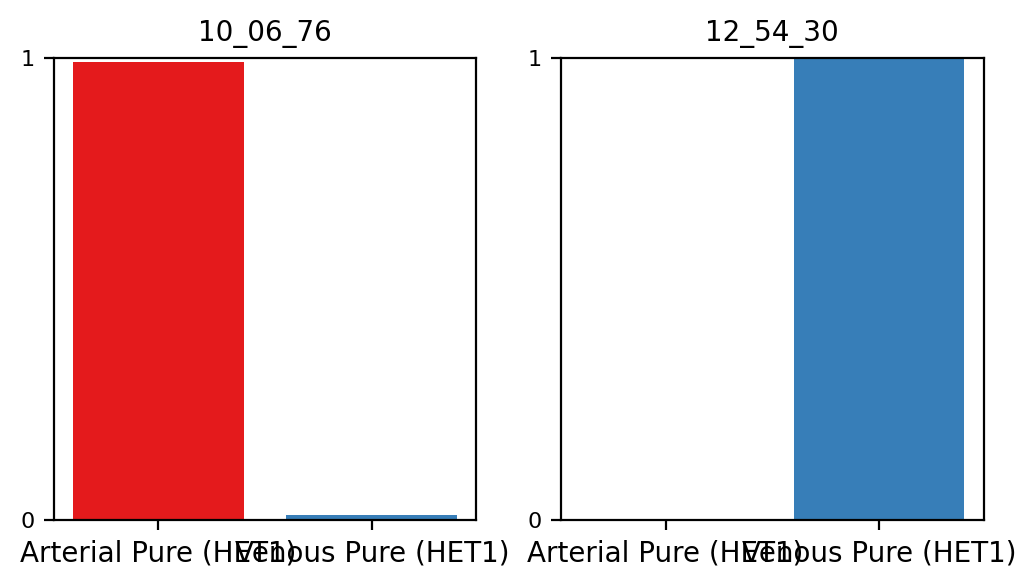

In [ ]:
cells = [
    arterial_cell_id,
    venous_cell_id

]
palantir.plot.plot_terminal_state_probs(adata, cells)
plt.show()

plan for tomorrow, i am going to complete the palantir psudo time and maybe dpt then perform dynamo implementation with the psudo time.

In [ ]:

masks = palantir.presults.select_branch_cells(adata, q=.001, eps=.01)

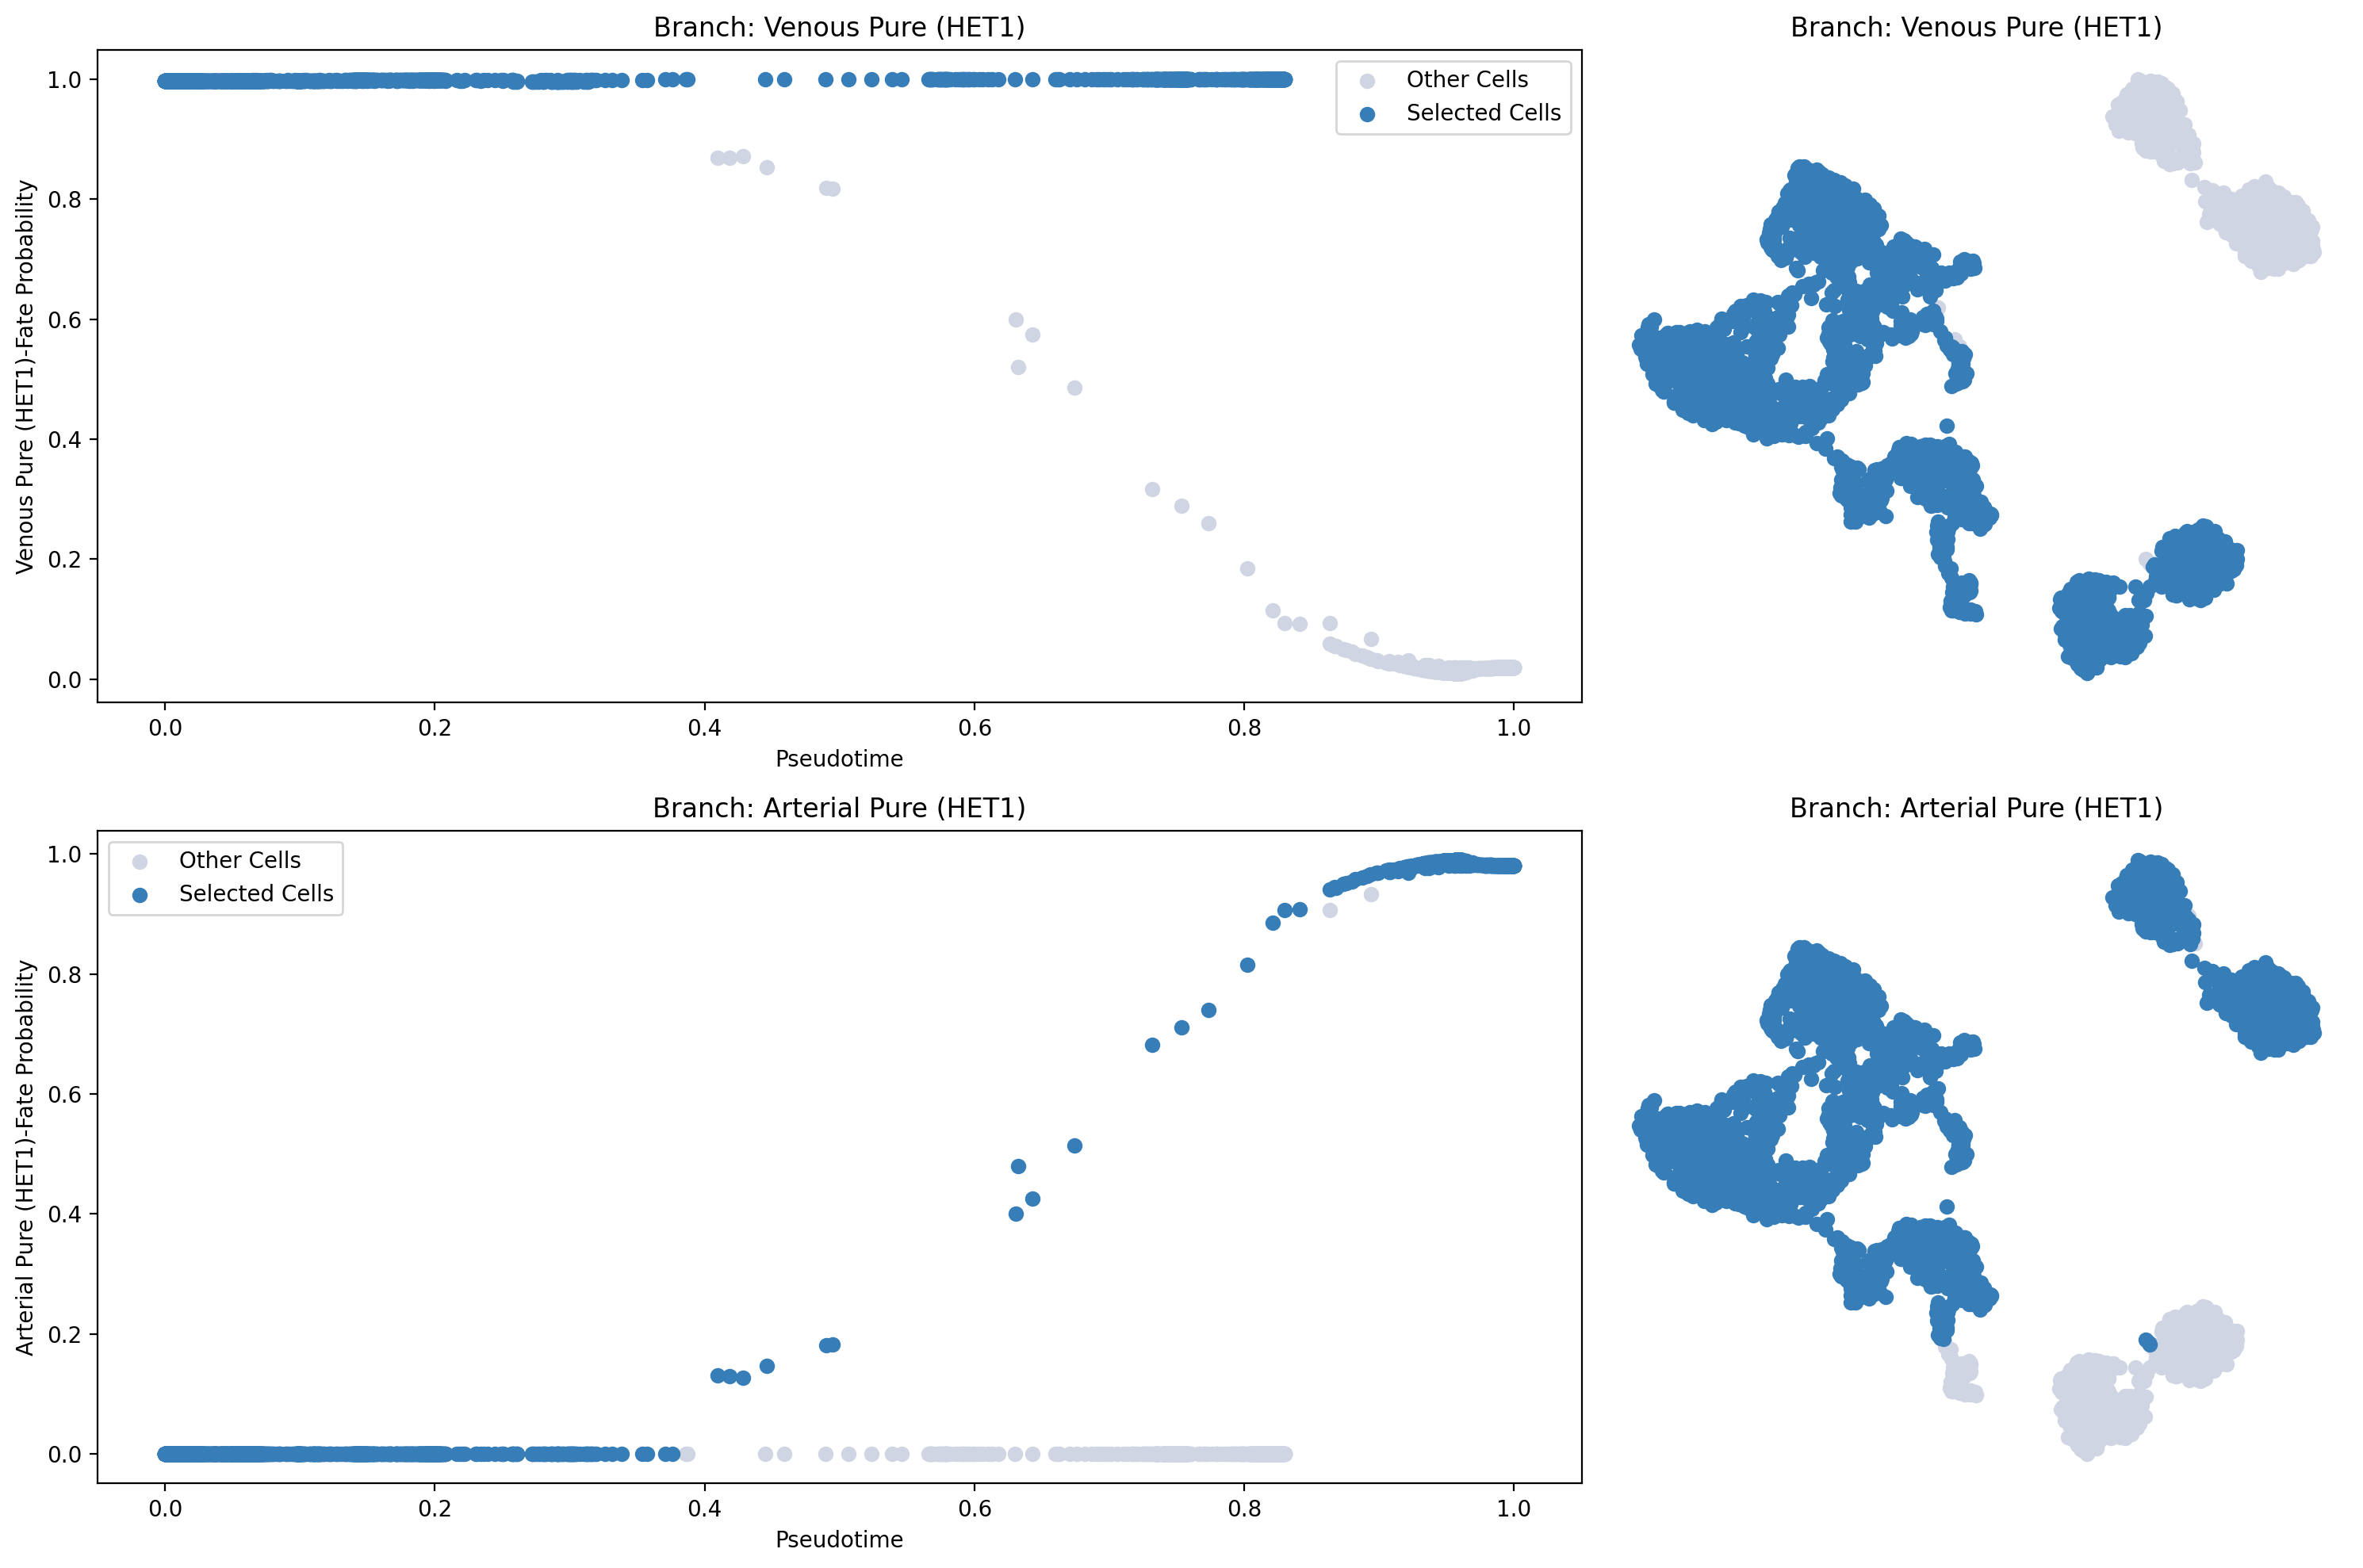

In [ ]:

palantir.plot.plot_branch_selection(adata)
plt.show()

questions for ralitsa: should i have endpoint be between the 2 as they are functionally similar or should i have terminal nodes be in each of the clusters, leading to 4 end points

In [ ]:
palantir.plot.highlight_cells_on_umap(adata, terminal_states)


(<Figure size 600x600 with 1 Axes>, <Axes: >)

## Pseudo Time Comparison


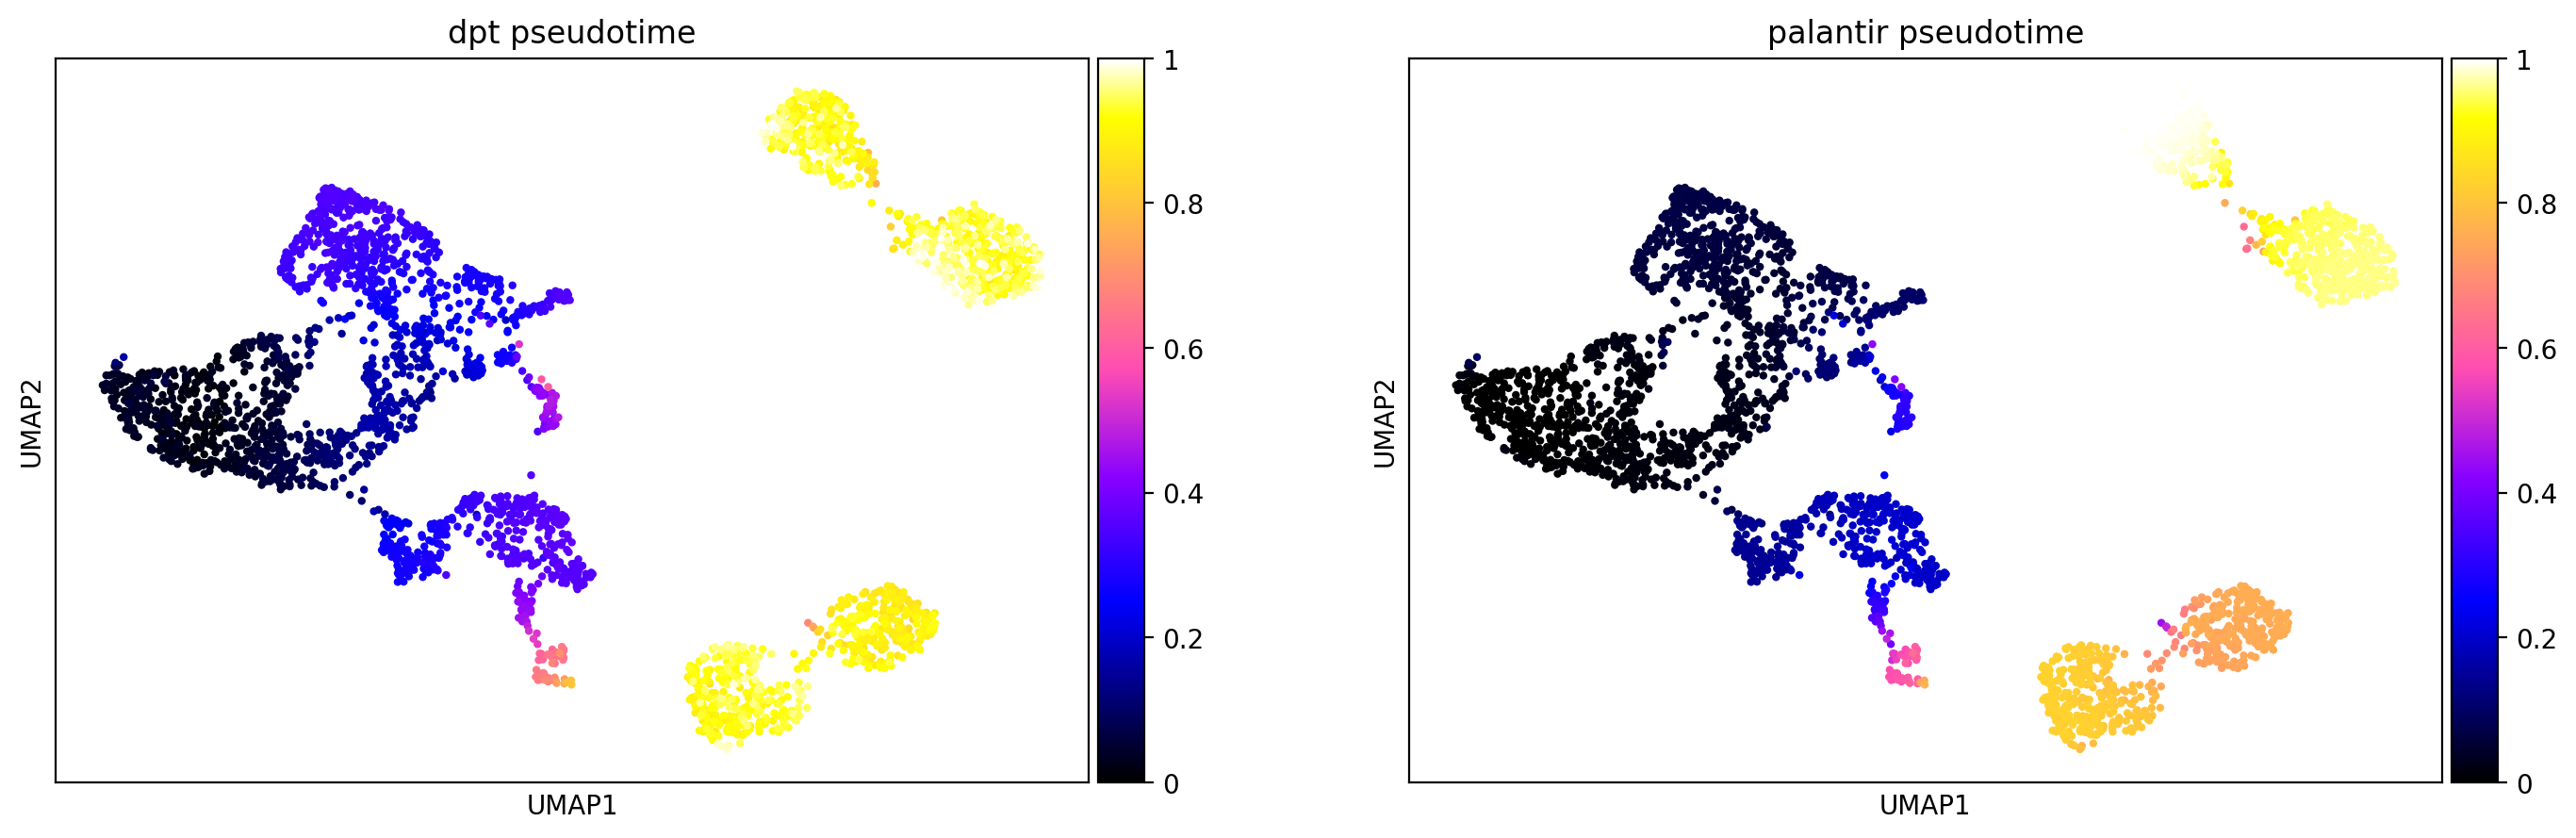

In [ ]:
sc.pl.scatter(
    adata,
    basis="umap",
    color=["dpt_pseudotime", "palantir_pseudotime"],
    color_map="gnuplot2",
)

it can be seen here that dpt pseudo time is working far better than palantir as there is a more gradual trajectory gradient. Both suitably establish that the pure cells are the final states and the LPM is the starting however palantir has majority of arterial cells as early pseudo whihc is incorect

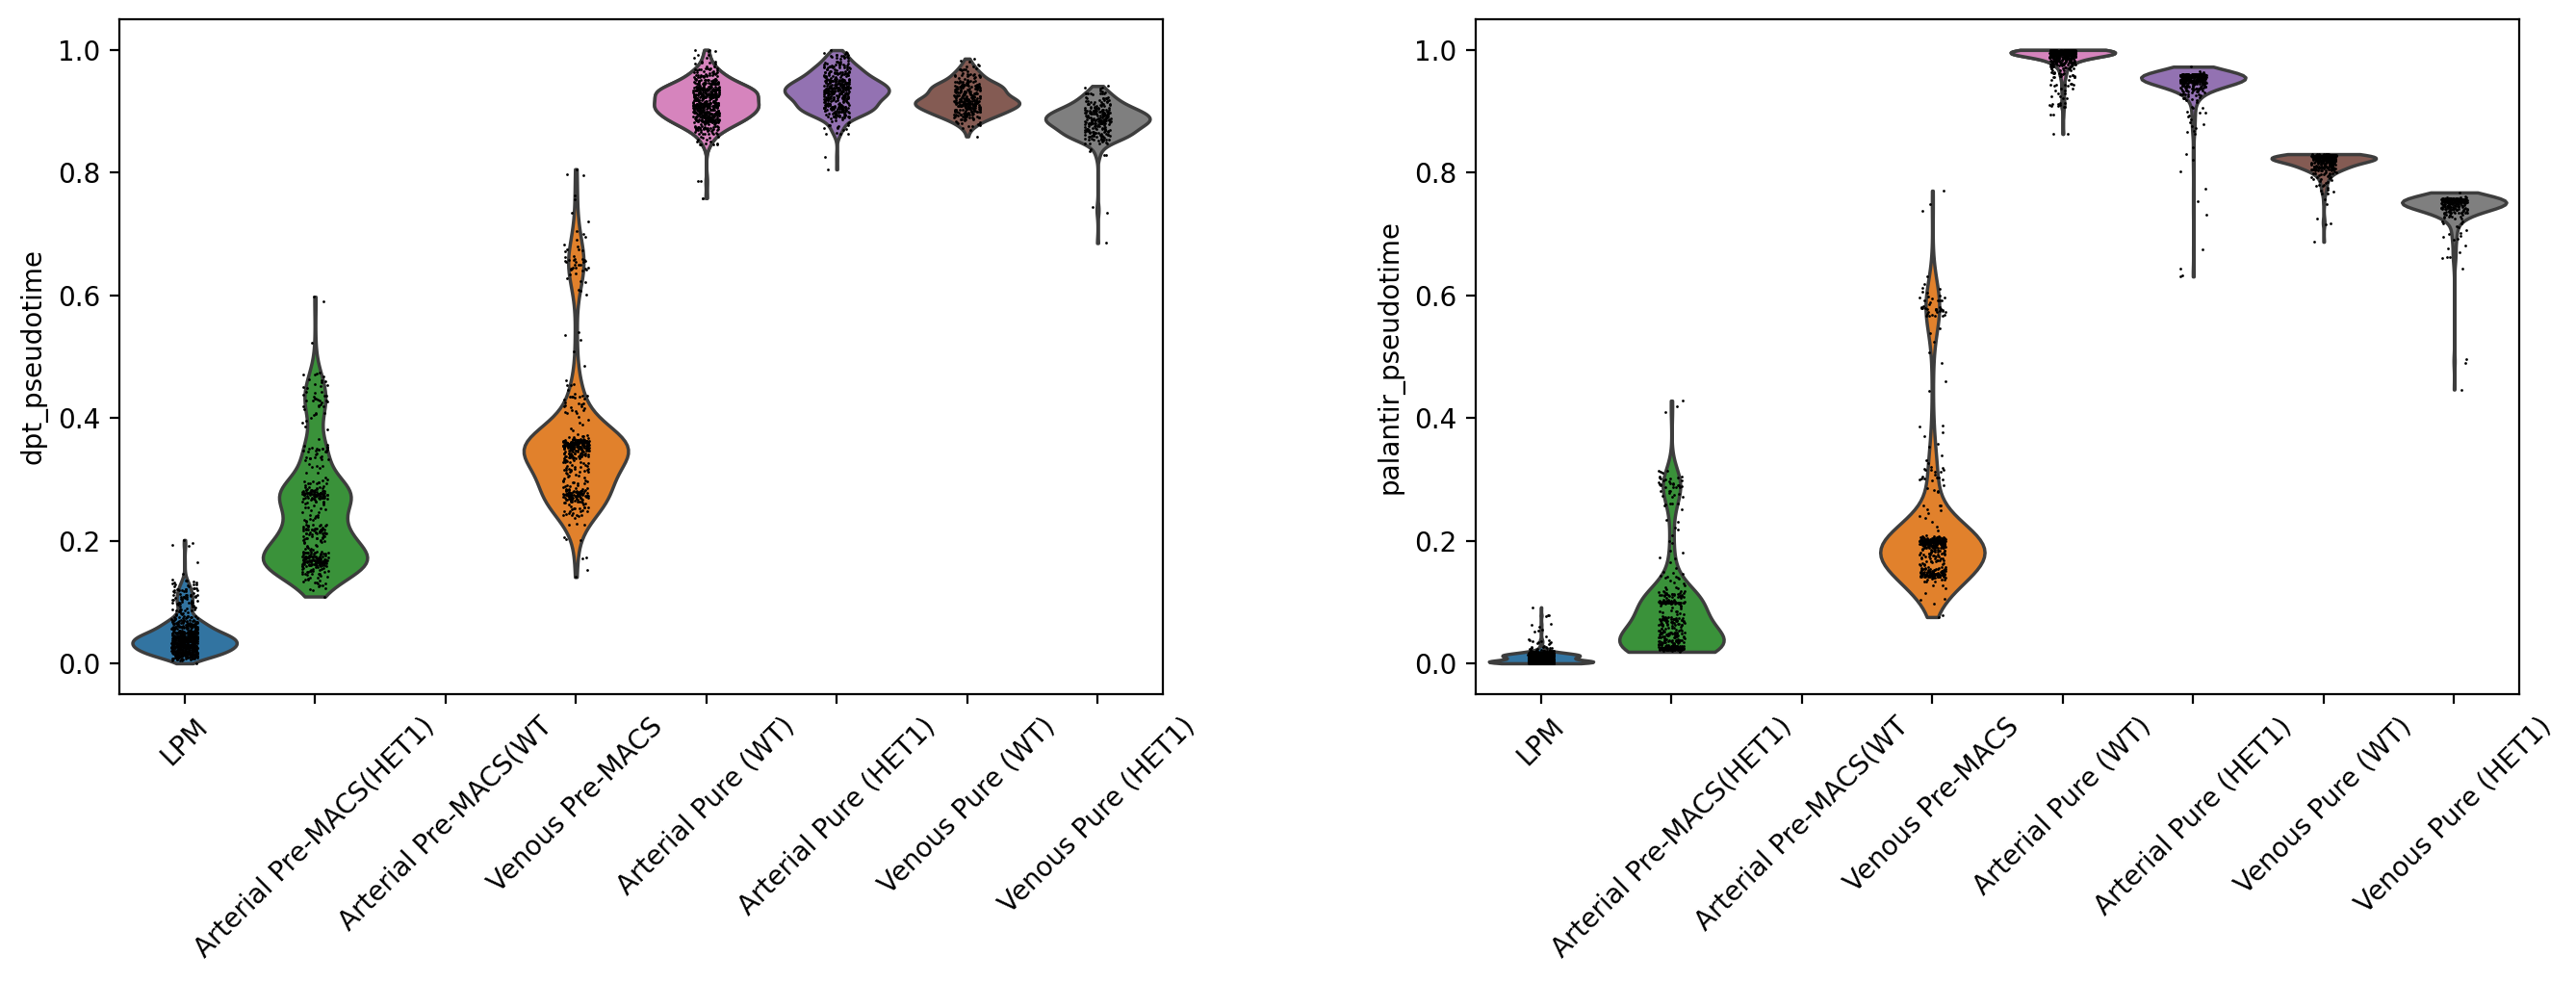

In [ ]:
sc.pl.violin(
    adata,
    keys=["dpt_pseudotime", "palantir_pseudotime"],
    groupby="cluster_identity",
    rotation=45,
    order=[
        "LPM",
        "Arterial Pre-MACS(HET1)",
        "Arterial Pre-MACS(WT",
        "Venous Pre-MACS",
        "Arterial Pure (WT)",
        "Arterial Pure (HET1)",
        "Venous Pure (WT)",
        "Arterial Pure (WT)",
        "Venous Pure (HET1)"
    ],
)



# Data Exportation
Export data for use in dynamo implementation

In [ ]:
#adata.write_h5ad('/content/drive/My Drive/Colab Notebooks/NSC3001/anndata_pseudotime.h5ad')
